In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree, preprocessing, metrics, model_selection, linear_model
from sklearn import model_selection

# Caminho para o arquivo CSV
file_path = "data/01_raw/kobe_shot.csv"

# Para data analise e visualização
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Carregar o arquivo CSV usando o Pandas
data = pd.read_csv(file_path)

# Verificar a quantidade de valores nulos ou vazios na coluna shot_made_flag
num_null_values = data['shot_made_flag'].isnull().sum()
print(num_null_values)

data.head(6)


5000


,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6


In [14]:
#drop rows with na values in the target feature and reset the index so we dont have anything missing
data = data[data['shot_made_flag'].notnull()].reset_index() 

data['period'].unique()

# 12 minutes per period but it is a countdown so we subtract from 11
data['minutes_from_period_start'] = 11 - data['minutes_remaining']
data['seconds_from_period_start'] = 60*data['minutes_from_period_start'] + (60 - data['seconds_remaining']) 
# overtime lasts 5 minutes
data['minutes_from_game_start'] = (data['period'] <= 4).astype(int)*((data['period'] - 1 )*12 + data['minutes_from_period_start']) \
+ (data['period'] > 4).astype(int)*((data['period'] - 5)*5 + 4*12 + data['minutes_from_period_start'])
data['seconds_from_game_start'] = (data['period'] <= 4).astype(int)*((data['period'] - 1 )*12*60 + data['seconds_from_period_start']) \
+ (data['period'] > 4).astype(int)*((data['period'] - 5)*5*60 + 4*12*60 + data['minutes_from_period_start'])

data['game_date'] = pd.to_datetime(data['game_date'])
data['game_day'] = data['game_date'].apply(lambda x: x.weekday())

data_cl = data.copy() # create a copy of the already cleaned from null values data frame
target = data_cl['shot_made_flag'].copy()


# Create new features
data_cl['game_year'] = data_cl['game_date'].apply(lambda x: x.year)
data_cl['game_month'] = data_cl['game_date'].apply(lambda x: x.month)

# Replace 20 least common action types with value 'Other'
rare_action_types = data_cl['action_type'].value_counts().sort_values().index.values[:20]
data_cl.loc[data_cl['action_type'].isin(rare_action_types), 'action_type'] = 'Other'

# Loc_x, and loc_y binning to group similar values together and not have a simingly continuous variable
data_cl['loc_x'] = pd.cut(data_cl['loc_x'], 25)
data_cl['loc_y'] = pd.cut(data_cl['loc_y'], 25)

# Home/Away game based on 'matchup' feature
data_cl['home_play'] = data_cl['matchup'].str.contains('vs').astype('int')
data_cl.drop('matchup', axis=1, inplace=True)

# Remove some columns
data_cl.drop('team_id', axis=1, inplace=True) # Always one number
data_cl.drop('lat', axis=1, inplace=True) # Correlated with loc_x
data_cl.drop('lon', axis=1, inplace=True) # Correlated with loc_y
data_cl.drop('game_id', axis=1, inplace=True) # Independent 
data_cl.drop('game_event_id', axis=1, inplace=True) # Independent
data_cl.drop('team_name', axis=1, inplace=True) # Always LA Lakers
data_cl.drop('shot_made_flag', axis=1, inplace=True)
data_cl.drop('minutes_remaining', axis=1, inplace=True) # Correlated with seconds_from_game_start
data_cl.drop('seconds_remaining', axis=1, inplace=True) # Correlated with seconds_from_game_start
data_cl.drop('minutes_from_period_start', axis=1, inplace=True) # Correlated with seconds_from_game_start
data_cl.drop('minutes_from_game_start', axis=1, inplace=True) # Correlated with seconds_from_game_start
data_cl.drop('seconds_from_period_start', axis=1, inplace=True) # Correlated with seconds_from_game_start + period
data_cl.drop('game_date', axis=1, inplace=True) # Correlated with  game_year,game_month,game_day
data_cl.drop('index', axis=1, inplace=True) 
kobe_shot = data_cl

In [15]:
data_cl.head(1).T

,0
action_type,Jump Shot
combined_shot_type,Jump Shot
loc_x,"(-170.32, -150.4]"
loc_y,"(-10.6, 22.8]"
period,1
playoffs,0
season,2000-01
shot_distance,15
shot_type,2PT Field Goal
shot_zone_area,Left Side(L)


In [2]:
from pycaret.classification import setup, compare_models, predict_model, create_model,predict_model
import numpy as np

data_transformed = data
data_transformed = data_transformed.dropna(subset=['shot_made_flag'])

print(f"Número de linhas antes da remoção: {len(data)}")
print(f"Número de linhas após a remoção: {len(data_transformed)}")

setup(data_transformed, target='shot_made_flag', categorical_features=['action_type', 'combined_shot_type'])

Número de linhas antes da remoção: 30697
Número de linhas após a remoção: 25697


,Description,Value
0,Session id,7067
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(25697, 25)"
4,Transformed data shape,"(25697, 30)"
5,Transformed train set shape,"(17987, 30)"
6,Transformed test set shape,"(7710, 30)"
7,Numeric features,13
8,Categorical features,2
9,Preprocess,True


In [6]:
def eval_metrics(pred):
    actual = pred['shot_made_flag']
    pred = pred['prediction_label']
    return (metrics.precision_score(actual, pred), 
            metrics.recall_score(actual, pred),
            metrics.f1_score(actual, pred))

In [7]:
# Comparar modelos disponíveis
best_model = compare_models()
    
# Treinar o melhor modelo
final_model = create_model(best_model)

# Fazer previsões usando o modelo treinado
predictions = predict_model(final_model, data_transformed)

(precision, recall, f1) = eval_metrics(predictions)
cm =  metrics.confusion_matrix(predictions["shot_made_flag"], predictions['prediction_label'])


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6567,0.0000,0.4846,0.6562,0.5574,0.2872,0.2961,0.2210
dummy,Dummy Classifier,0.5538,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0400


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6509,0.0000,0.4751,0.6480,0.5482,0.2746,0.2834
1,0.6715,0.0000,0.5050,0.6761,0.5782,0.3183,0.3274
2,0.6598,0.0000,0.4956,0.6579,0.5653,0.2949,0.3028
3,0.6637,0.0000,0.4919,0.6672,0.5663,0.3018,0.3112
4,0.6504,0.0000,0.4819,0.6450,0.5517,0.2748,0.2827
5,0.6565,0.0000,0.4682,0.6631,0.5489,0.2846,0.2958
6,0.6543,0.0000,0.4944,0.6476,0.5607,0.2840,0.2911
7,0.6385,0.0000,0.4701,0.6262,0.5370,0.2502,0.2572
8,0.6707,0.0000,0.4900,0.6823,0.5704,0.3149,0.3263


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7445,0.8176,0.5973,0.7785,0.6760,0.4711,0.4824


In [3]:
import psutil
import subprocess
    
# Verificar todos os processos em execução
for process in psutil.process_iter():
    try:
        #Verificar se o processo é 'mlflow'
        if 'mlflow' in process.name():
            print("Interface do MLflow está em execução.")
    except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
        pass
        print("Interface do MLflow não está em execução.")
        # Executar o comando 'kedro mlflow ui' no terminal
        subprocess.run(['kedro', 'mlflow', 'ui'])

In [7]:
# Seu DataFrame de exemplo
data = {
    'A': [1, 2, 3],
    'B': ['foo', 'bar', 'baz']
}

df = pd.DataFrame(data)

# Salvar o DataFrame em um arquivo .parquet
df.to_parquet('data.parquet')


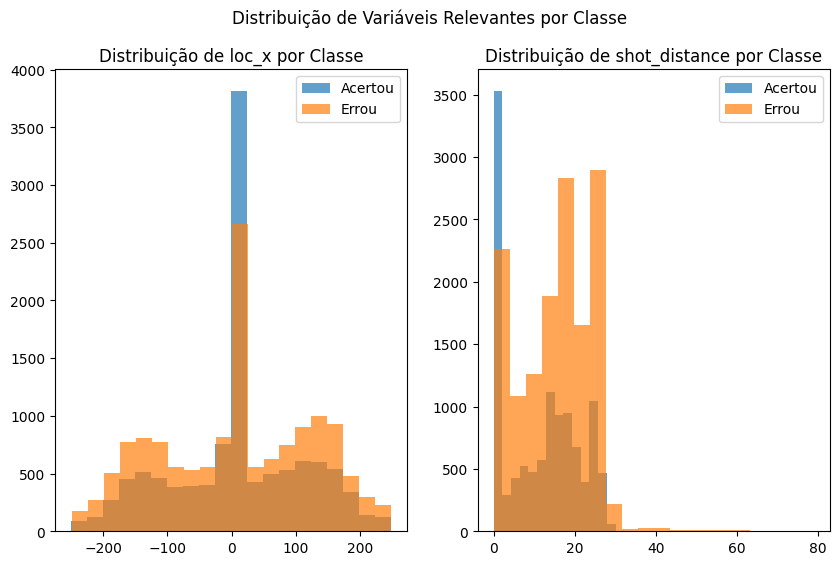

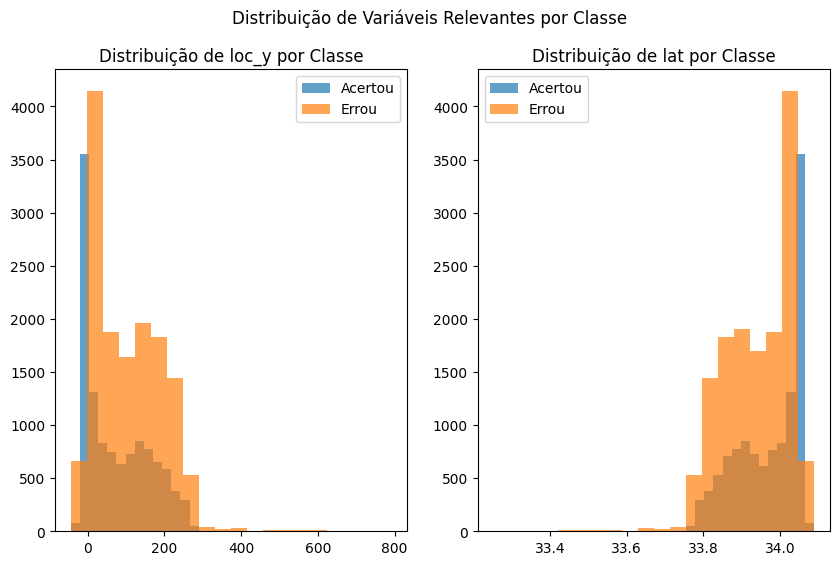

NameError: name 'mlflow' is not defined

In [7]:

    plot_path = 'data/08_reporting/histogram_kobe_shot.png'
    
    # Separar dados por classe
    data_acerto = data[data['shot_made_flag'] == 1]
    data_erro = data[data['shot_made_flag'] == 0]
    
    # Analisar variáveis relevantes para cada classe
    
    # Acertou o arremesso
    plt.figure(figsize=(10, 6))
    
    # loc_x
    plt.subplot(1, 2, 1)
    plt.hist(data_acerto['loc_x'], bins=20, alpha=0.7, label='Acertou')
    plt.hist(data_erro['loc_x'], bins=20, alpha=0.7, label='Errou')
    plt.legend()
    plt.title('Distribuição de loc_x por Classe')
    
    # shot_distance
    plt.subplot(1, 2, 2)
    plt.hist(data_acerto['shot_distance'], bins=20, alpha=0.7, label='Acertou')
    plt.hist(data_erro['shot_distance'], bins=20, alpha=0.7, label='Errou')
    plt.legend()
    plt.title('Distribuição de shot_distance por Classe')
    
    plt.suptitle('Distribuição de Variáveis Relevantes por Classe')
    plt.show()
    
    # Errou o arremesso
    plt.figure(figsize=(10, 6))
    
    # loc_y
    plt.subplot(1, 2, 1)
    plt.hist(data_acerto['loc_y'], bins=20, alpha=0.7, label='Acertou')
    plt.hist(data_erro['loc_y'], bins=20, alpha=0.7, label='Errou')
    plt.legend()
    plt.title('Distribuição de loc_y por Classe')
    
    # lat
    plt.subplot(1, 2, 2)
    plt.hist(data_acerto['lat'], bins=20, alpha=0.7, label='Acertou')
    plt.hist(data_erro['lat'], bins=20, alpha=0.7, label='Errou')
    plt.legend()
    plt.title('Distribuição de lat por Classe')
    
    plt.suptitle('Distribuição de Variáveis Relevantes por Classe')

    plt.savefig(plot_path)
    plt.show()
    mlflow.log_artifact(plot_path)

In [4]:
    X = data.drop(columns=['shot_made_flag'])
    y = data['shot_made_flag']
    
    # Separar os dados em treino e teste (80% treino, 20% teste) com divisão estratificada
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Exibir as formas dos conjuntos de treino e teste
    print("Forma do conjunto de treino (X):", X_train.shape)
    print("Forma do conjunto de teste (X):", X_test.shape)
    print("Forma do conjunto de treino (y):", y_train.shape)
    print("Forma do conjunto de teste (y):", y_test.shape)

    # Logs de treinos e teste
    print(X_train.shape)
    print(y_train.shape)

    print(X_test.shape)
    print(y_test.shape)

    # Salvar o conjunto de treino em um arquivo .parquet
    train_data = pd.concat([X_train, y_train], axis=1)
    data.to_parquet("data/04_feature/base_train.parquet", index=False)

    # Salvando dados de teste
    test_data = pd.concat([X_test, y_test], axis=1)
    test_data.to_parquet("data/04_feature/base_test.parquet", index=False)

Forma do conjunto de treino (X): (20557, 30)
Forma do conjunto de teste (X): (5140, 30)
Forma do conjunto de treino (y): (20557,)
Forma do conjunto de teste (y): (5140,)
(20557, 30)
(20557,)
(5140, 30)
(5140,)


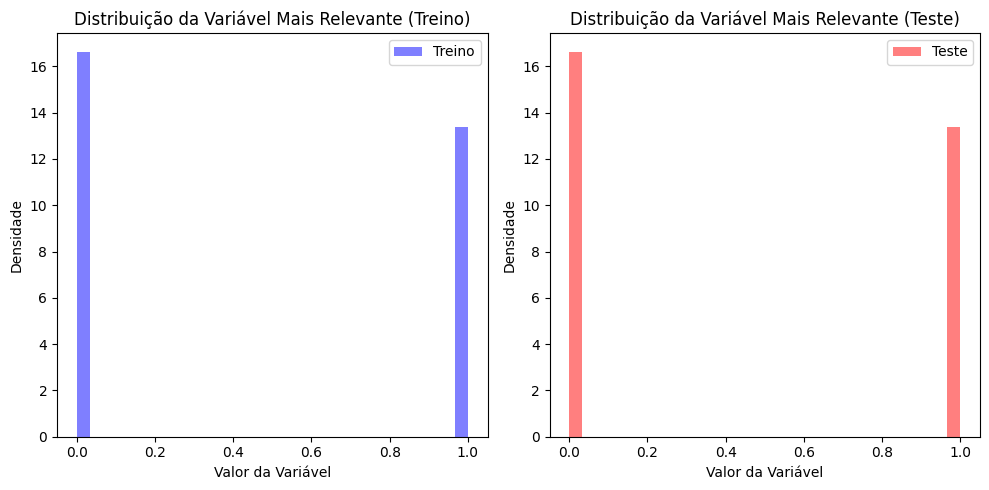

In [5]:
# Identificar a variável mais relevante (por exemplo, variável alvo)
variavel_mais_relevante = 'shot_made_flag'

# Plotar histograma/densidade para a variável mais relevante nos conjuntos de treinamento e teste
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, alpha=0.5, color='blue', label='Treino', density=True)
plt.title('Distribuição da Variável Mais Relevante (Treino)')
plt.xlabel('Valor da Variável')
plt.ylabel('Densidade')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(y_test, bins=30, alpha=0.5, color='red', label='Teste', density=True)
plt.title('Distribuição da Variável Mais Relevante (Teste)')
plt.xlabel('Valor da Variável')
plt.ylabel('Densidade')
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
kobe_shot_data = data

# Tratamento de dados: converter variáveis não numéricas em numéricas
kobe_shot_data['action_type'] = pd.Categorical(kobe_shot_data['action_type']).codes
kobe_shot_data['combined_shot_type'] = pd.Categorical(kobe_shot_data['combined_shot_type']).codes
kobe_shot_data['shot_type'] = pd.Categorical(kobe_shot_data['shot_type']).codes
kobe_shot_data['shot_zone_basic'] = pd.Categorical(kobe_shot_data['shot_zone_basic']).codes
kobe_shot_data['shot_zone_area'] = pd.Categorical(kobe_shot_data['shot_zone_area']).codes
kobe_shot_data['shot_zone_range'] = pd.Categorical(kobe_shot_data['shot_zone_range']).codes
kobe_shot_data['team_name'] = pd.Categorical(kobe_shot_data['team_name']).codes
kobe_shot_data['matchup'] = pd.Categorical(kobe_shot_data['matchup']).codes
kobe_shot_data['opponent'] = pd.Categorical(kobe_shot_data['opponent']).codes
kobe_shot_data = kobe_shot_data.drop(columns=["game_date"])

# Mapear cada valor único para um número inteiro
mapping = {valor: indice + 1 for indice, valor in enumerate(data_cl['season'].unique())}

# Criar uma nova coluna com os valores mapeados
data_cl['season'] = data_cl['season'].map(mapping)


# Verificar os tipos de dados das colunas após o tratamento
print(kobe_shot_data.dtypes)

index                          int64
action_type                     int8
combined_shot_type              int8
game_event_id                  int64
game_id                        int64
lat                          float64
loc_x                          int64
loc_y                          int64
lon                          float64
minutes_remaining              int64
period                         int64
playoffs                       int64
season                        object
seconds_remaining              int64
shot_distance                  int64
shot_made_flag               float64
shot_type                       int8
shot_zone_area                  int8
shot_zone_basic                 int8
shot_zone_range                 int8
team_id                        int64
team_name                       int8
matchup                         int8
opponent                        int8
shot_id                        int64
minutes_from_period_start      int64
seconds_from_period_start      int64
m

Número de linhas antes da remoção: 25697
Número de linhas após a remoção: 25697


,Description,Value
0,Session id,3604
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(25697, 30)"
4,Transformed data shape,"(25697, 35)"
5,Transformed train set shape,"(17987, 35)"
6,Transformed test set shape,"(7710, 35)"
7,Numeric features,27
8,Categorical features,2
9,Preprocess,True


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5542,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.5542,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.5570,0.0000,0.0237,0.5938,0.0455,0.0117,0.0399
3,0.5536,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.5503,0.0000,0.0224,0.4286,0.0426,-0.0019,-0.0055
5,0.5509,0.0000,0.0137,0.4074,0.0265,-0.0026,-0.0097
6,0.5670,0.0000,0.2914,0.5270,0.3753,0.0842,0.0929
7,0.5667,0.0000,0.2830,0.5267,0.3682,0.0819,0.0911
8,0.5534,0.0000,0.0162,0.4815,0.0314,0.0024,0.0088


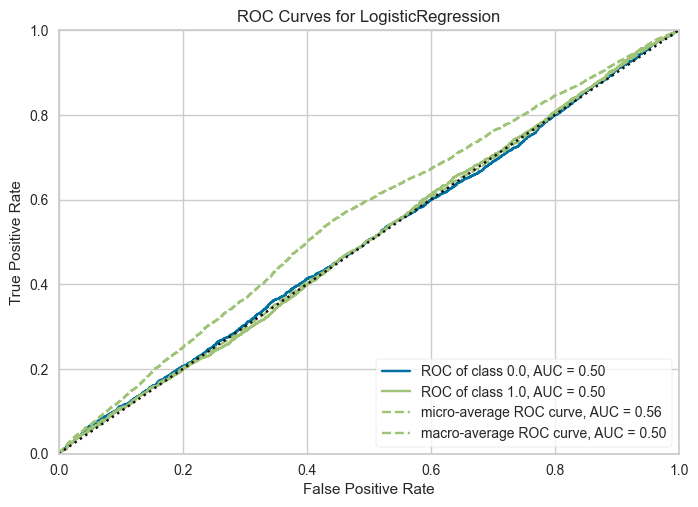

In [51]:
from pycaret.classification import setup, compare_models, save_model, create_model, plot_model, predict_model
import numpy as np

data_transformed = kobe_shot_data
data_transformed = data_transformed.dropna(subset=['shot_made_flag'])

print(f"Número de linhas antes da remoção: {len(data)}")
print(f"Número de linhas após a remoção: {len(data_transformed)}")

# Mapear cada valor único para um número inteiro
mapping = {valor: indice + 1 for indice, valor in enumerate(data_transformed['season'].unique())}

# Criar uma nova coluna com os valores mapeados
data_transformed['season'] = data_transformed['season'].map(mapping)

setup(data_transformed, target='shot_made_flag', categorical_features=['action_type', 'combined_shot_type'])
lr_model = create_model('lr', cross_validation=True)
# Plotar a curva de validação
plot_model(lr_model, plot='auc')

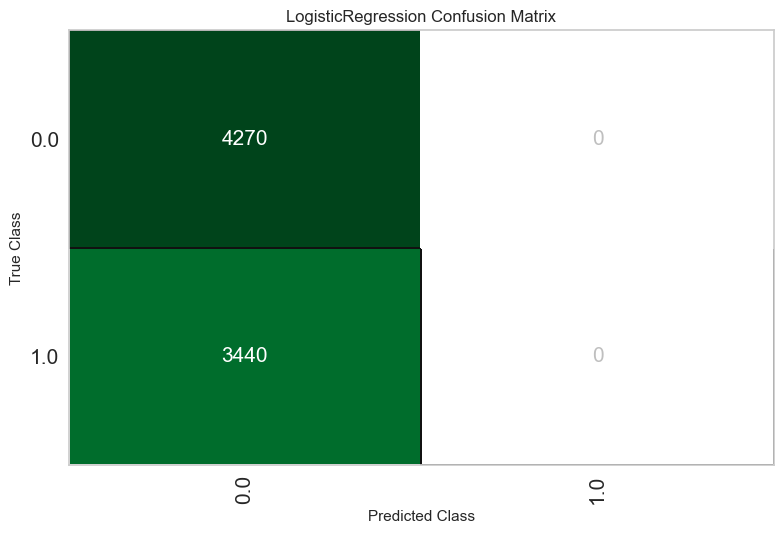

In [52]:
plot_model(lr_model, plot='confusion_matrix')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5798,0.0000,0.5486,0.5276,0.5379,0.1528,0.1529
1,0.5803,0.0000,0.5549,0.5279,0.5410,0.1549,0.1551
2,0.5737,0.0000,0.5280,0.5222,0.5251,0.1383,0.1383
3,0.5981,0.0000,0.5791,0.5471,0.5626,0.1914,0.1917
4,0.5592,0.0000,0.4807,0.5066,0.4933,0.1037,0.1038
5,0.5609,0.0000,0.5243,0.5078,0.5159,0.1143,0.1143
6,0.5853,0.0000,0.5430,0.5350,0.5389,0.1622,0.1622
7,0.5723,0.0000,0.5025,0.5213,0.5117,0.1315,0.1315
8,0.5895,0.0000,0.5337,0.5404,0.5370,0.1684,0.1684


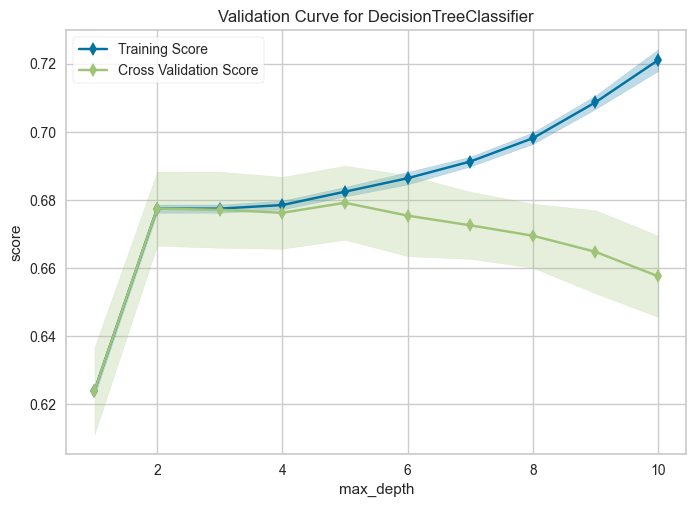

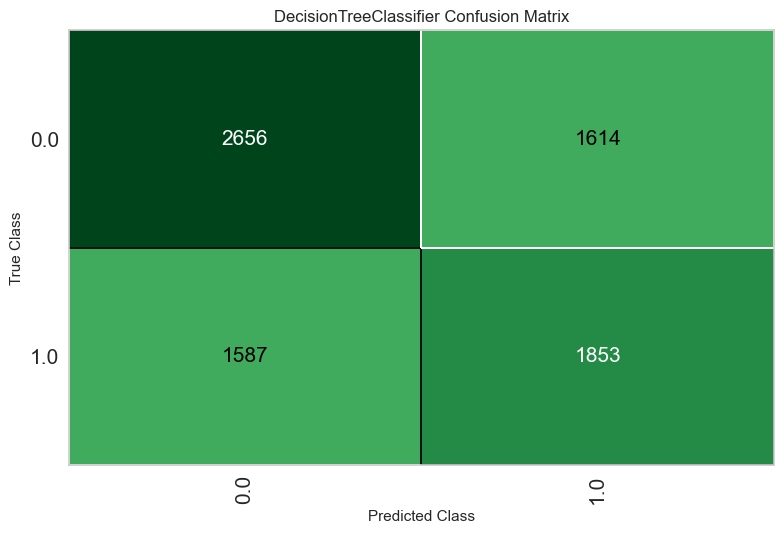

In [54]:
model_arvore = create_model('dt')

# Plotar a curva de validação da Árvore de Decisão
plot_model(model_arvore, plot='vc')
plot_model(model_arvore, plot='confusion_matrix')

In [55]:
 # Comparar modelos disponíveis
best_model = compare_models()
    
# Treinar o melhor modelo
final_model = create_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6791,0.0000,0.4606,0.7194,0.5613,0.3271,0.3475,0.7600
ada,Ada Boost Classifier,0.6782,0.0000,0.4613,0.7166,0.5610,0.3254,0.3452,0.2430
lightgbm,Light Gradient Boosting Machine,0.6753,0.0000,0.4508,0.7168,0.5530,0.3184,0.3398,0.2140
rf,Random Forest Classifier,0.6615,0.0000,0.4733,0.6712,0.5549,0.2949,0.3067,0.6410
et,Extra Trees Classifier,0.6418,0.0000,0.4604,0.6362,0.5340,0.2552,0.2640,0.3820
lda,Linear Discriminant Analysis,0.6183,0.0000,0.3389,0.6354,0.4418,0.1910,0.2128,0.0810
ridge,Ridge Classifier,0.6181,0.0000,0.3382,0.6351,0.4410,0.1903,0.2122,0.1400
qda,Quadratic Discriminant Analysis,0.5922,0.0000,0.3712,0.6390,0.4217,0.1483,0.1836,0.0690
dt,Decision Tree Classifier,0.5797,0.0000,0.5348,0.5285,0.5315,0.1505,0.1505,0.1680
nb,Naive Bayes,0.5566,0.0000,0.1485,0.5116,0.2294,0.0363,0.0503,0.0700


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6693,0.0000,0.4663,0.6913,0.5570,0.3087,0.3239
1,0.6876,0.0000,0.4875,0.7214,0.5818,0.3471,0.3641
2,0.6654,0.0000,0.4471,0.6944,0.5439,0.2987,0.3168
3,0.6765,0.0000,0.4707,0.7065,0.5650,0.3236,0.3405
4,0.6604,0.0000,0.4035,0.7105,0.5147,0.2828,0.3096
5,0.6971,0.0000,0.4795,0.7520,0.5856,0.3647,0.3877
6,0.6709,0.0000,0.4483,0.7073,0.5488,0.3097,0.3297
7,0.6835,0.0000,0.4564,0.7335,0.5626,0.3352,0.3584
8,0.6969,0.0000,0.4788,0.7515,0.5849,0.3642,0.3872


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6693,0.0000,0.4663,0.6913,0.5570,0.3087,0.3239
1,0.6876,0.0000,0.4875,0.7214,0.5818,0.3471,0.3641
2,0.6654,0.0000,0.4471,0.6944,0.5439,0.2987,0.3168
3,0.6765,0.0000,0.4707,0.7065,0.5650,0.3236,0.3405
4,0.6604,0.0000,0.4035,0.7105,0.5147,0.2828,0.3096
5,0.6971,0.0000,0.4795,0.7520,0.5856,0.3647,0.3877
6,0.6709,0.0000,0.4483,0.7073,0.5488,0.3097,0.3297
7,0.6835,0.0000,0.4564,0.7335,0.5626,0.3352,0.3584
8,0.6969,0.0000,0.4788,0.7515,0.5849,0.3642,0.3872


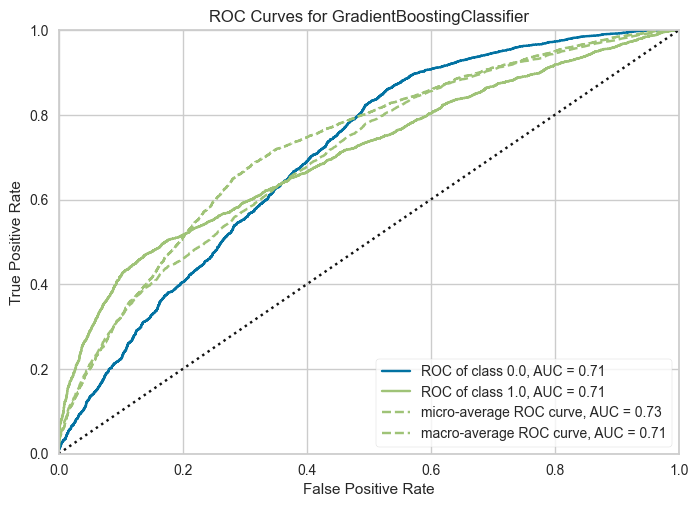

In [56]:
# Criar e avaliar o modelo de Gradient Boosting Classifier (GBC)
gbc_model = create_model('gbc')

# Plotar a curva ROC do grupo de teste com a árvore de decisão
plot_model(best_model, plot='auc')

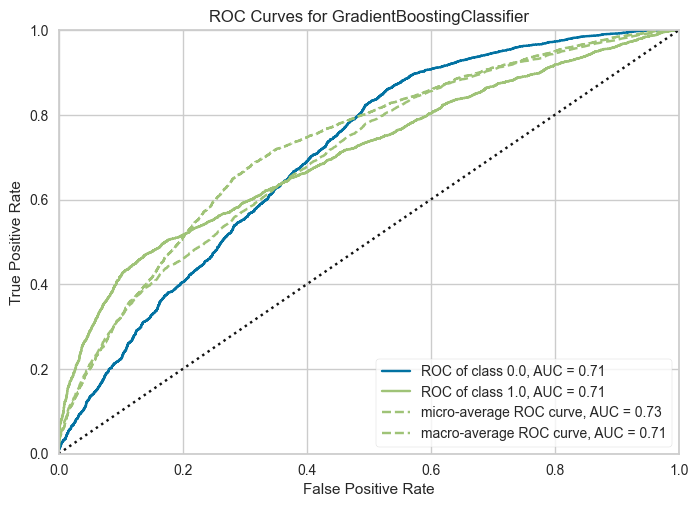

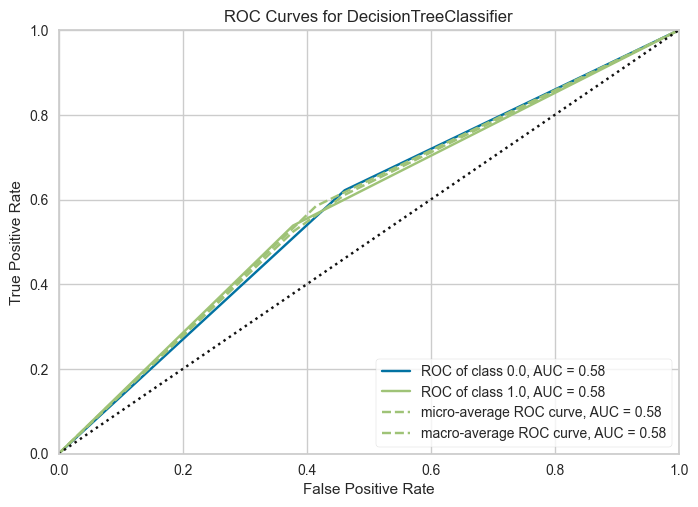

In [58]:
plot_model(gbc_model, plot='auc')
plot_model(model_arvore, plot='auc')

In [ ]:
from flask import Flask, request, jsonify
import pickle

app = Flask(__name__)

# Carregar o modelo
with open('data/07_model_output/pycaret_model_1.pkl', 'rb') as file:
    modelo = pickle.load(file)

# Rota para predições
@app.route('/predict', methods=['POST'])
def predict():
    # Receber os dados da requisição
    data = request.json
    
    # Fazer a predição usando o modelo
    prediction = model.predict_proba(pd.DataFrame([data]))[:,1]
    
    # Retornar a predição
    return jsonify({'prediction': prediction.tolist()})

if __name__ == '__main__':
    app.run()

In [29]:
import requests

# URL da Web API
url = 'http://localhost:5000/predict'

# Dados para a predição (valores reais do conjunto de dados)
data = {
    'features': {
        'action_type':26,
        'combined_shot_type':3,
        'game_event_id': 12,
        'game_id': 20000012,
        'loc_x': -157,
        'loc_y': 0,
        'season': 1,
        'seconds_remaining': 22,
        'shot_distance': 15,
        'shot_type': 0,
        'shot_zone_area': 3,
        'shot_zone_basic': 4,
        'team_id': 1610612747,
        'team_name': 0,
        'matchup': 28,
        'opponent': 25,
        'shot_id': 2
    }
}
#26,3,12,20000012,-157,0,1,22,15,0.0,0,3,4,1610612747,0,28,25,2


# Enviar solicitação POST com os dados
response = requests.post(url, json=data)

# Verificar se a solicitação foi bem-sucedida
if response.status_code == 200:
    # Obter a previsão do JSON de resposta
    prediction = response.json()['prediction']
    print('Previsão:', prediction)
else:
    print('Erro ao fazer a solicitação:', response.text)

Previsão: [0.0]
